# ECO491: Homework 2

In [33]:
# Relevant basic Python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Question 1

Refer to written portion for the solution to question 1

## Question 2

In [63]:
# Question 2 Coding Portion

# ---------- Data Setup ----------
df_SPY_2010_2024 = pd.read_excel("../data/SPY_2010_2024.xlsx", index_col="Date")
df_SPY_2010_2024.index = pd.to_datetime(df_SPY_2010_2024.index)

df_SPY_log = np.log(df_SPY_2010_2024["Close Price"] /
                    df_SPY_2010_2024["Close Price"].shift(1))
df_SPY_log = df_SPY_log.iloc[1:]

time_series = []
for end in range(250, len(df_SPY_log) + 1):
    series = df_SPY_log.iloc[end-250:end]
    time_series.append(series)

index = df_SPY_log.index[249:]
df_ES = pd.DataFrame(index=index)
df_VaR = pd.DataFrame(index=index)

VaR_RM, VaR_HS, VaR_WHS1, VaR_WHS2 = [], [], [], []
Es_RM, Es_HS, Es_WHS1, Es_WHS2 = [], [], [], []

# ---------- Helpers ----------
def WHS_weights(decay, m):
    w = np.array([decay ** (m - i - 1) for i in range(m)], dtype=float)
    w /= w.sum()
    return w

def weighted_quantile(values, q, w):
    sorter = np.argsort(values)
    v = values[sorter]
    w = w[sorter]
    c = np.cumsum(w)
    cutoff = q * c[-1]
    idx = np.searchsorted(c, cutoff)
    idx = min(max(idx, 0), len(v)-1)
    return v[idx]

def weighted_ES(values, VaR_value, w):
    mask = values <= VaR_value
    if not np.any(mask):
        return VaR_value
    return np.sum(values[mask] * w[mask]) / np.sum(w[mask])

lambda_RM = 0.95
s1, s2 = 0.95, 0.99
quantile_level = 0.01

# ---------- Rolling Calculations ----------
for series in time_series:
    series = pd.Series(series)
    m = len(series)

    # RiskMetrics
    var = series.iloc[0]**2
    for r in series.iloc[1:]:
        var = lambda_RM * var + (1 - lambda_RM) * (r ** 2)
    sigma = np.sqrt(var)
    VaR_RM_val = -sigma * norm.ppf(quantile_level)
    ES_RM_val  = sigma * (norm.pdf(norm.ppf(quantile_level)) / quantile_level)
    VaR_RM.append([series.index[-1], VaR_RM_val])
    Es_RM.append([series.index[-1], ES_RM_val])

    # Historical Simulation
    VaR_HS_raw = series.quantile(quantile_level, interpolation="linear")
    VaR_HS_val = -VaR_HS_raw
    subset = series[series <= VaR_HS_raw]
    ES_HS_val = -subset.mean() if len(subset) else VaR_HS_val
    VaR_HS.append([series.index[-1], VaR_HS_val])
    Es_HS.append([series.index[-1], ES_HS_val])

    # Weighted HS
    values = series.values
    w1, w2 = WHS_weights(s1, m), WHS_weights(s2, m)

    VaR_w1_raw = weighted_quantile(values, quantile_level, w1)
    ES_w1_raw  = weighted_ES(values, VaR_w1_raw, w1)
    VaR_WHS1.append([series.index[-1], -VaR_w1_raw])
    Es_WHS1.append([series.index[-1], -ES_w1_raw])

    VaR_w2_raw = weighted_quantile(values, quantile_level, w2)
    ES_w2_raw  = weighted_ES(values, VaR_w2_raw, w2)
    VaR_WHS2.append([series.index[-1], -VaR_w2_raw])
    Es_WHS2.append([series.index[-1], -ES_w2_raw])

# ---------- Store in DataFrames ----------
for idx, val in VaR_RM:   df_VaR.loc[idx, 'RM']      = val
for idx, val in VaR_HS:   df_VaR.loc[idx, 'HS']      = val
for idx, val in VaR_WHS1: df_VaR.loc[idx, 'WHS_s1']  = val
for idx, val in VaR_WHS2: df_VaR.loc[idx, 'WHS_s2']  = val

for idx, val in Es_RM:    df_ES.loc[idx, 'RM']      = val
for idx, val in Es_HS:    df_ES.loc[idx, 'HS']      = val
for idx, val in Es_WHS1:  df_ES.loc[idx, 'WHS_s1']  = val
for idx, val in Es_WHS2:  df_ES.loc[idx, 'WHS_s2']  = val

# ---------- Comparisons ----------
def compare(col1, col2, label1, label2):
    count_VaR = np.sum(df_VaR[col1] > df_VaR[col2])
    count_ES  = np.sum(df_ES[col1]  > df_ES[col2])
    print(f"{label1} > {label2}  |  VaR: {count_VaR}  ES: {count_ES}")

# pairwise comparisons
compare("HS",     "WHS_s1", "HS",         "WHS s1")
compare("HS",     "WHS_s2", "HS",         "WHS s2")
compare("RM",     "HS",     "RiskMetrics","HS")
compare("RM",     "WHS_s1", "RiskMetrics","WHS s1")
compare("RM",     "WHS_s2", "RiskMetrics","WHS s2")

HS > WHS s1  |  VaR: 2577  ES: 2967
HS > WHS s2  |  VaR: 1780  ES: 2476
RiskMetrics > HS  |  VaR: 680  ES: 689
RiskMetrics > WHS s1  |  VaR: 1544  ES: 1895
RiskMetrics > WHS s2  |  VaR: 481  ES: 704


## Question 2 Written Portion

The ideas discussed in class were primarily that historical simulations are generally slower than the RiskMetrics model at adapting to new information and changing when there are spikes in volatility. Within the category of historical simulations, a weighted historical simulation was discussed to adapt faster, but still lacks the robust flexibility that the RiskMetrics model has.

Now, turning to the results, the number of exceedances is a useful proxy for adaptability. The results show:

HS > WHS s1: VaR: 2577, ES: 2967
HS > WHS s2: VaR: 1780, ES: 2476
RiskMetrics > HS: VaR: 680, ES: 689
RiskMetrics > WHS s1: VaR: 1544, ES: 1895
RiskMetrics > WHS s2: VaR: 481, ES: 704

HS exceeds WHS frequently, particularly with s1, showing that fixed-window historical simulations adapt slower to sudden volatility changes. WHS reduces exceedances compared to HS, and smaller decay factors (like s1) improve responsiveness by weighting recent data more heavily, though at some cost to stability. RiskMetrics has the fewest exceedances overall, confirming its superior adaptability due to its explicit modelling of time-varying volatility. These results align with class discussions: RiskMetrics reacts most quickly to market changes, WHS offers a compromise between speed and stability, and HS lags behind in responding to volatility shifts.

## Question 3

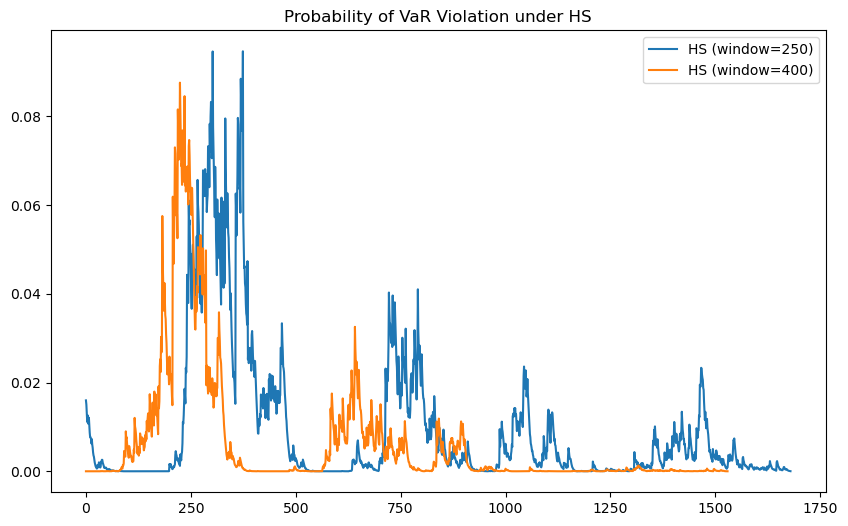

In [73]:
# Question 3 (a) Coding Portion

# ---------- Part (a): Simulated Returns with RiskMetrics DGP ----------
T = 1930
lambda_sim = 0.94

# initial variance from SPY returns
sigma2 = np.var(df_SPY_log, ddof=1)
sigma_t = np.sqrt(sigma2)

# simulate innovations
z = np.random.normal(0, 1, T)
R_sim, sigma_path = [], []

for t in range(T):
    Rt = sigma_t * z[t]
    R_sim.append(Rt)
    sigma2 = lambda_sim * sigma2 + (1 - lambda_sim) * Rt**2
    sigma_t = np.sqrt(sigma2)
    sigma_path.append(sigma_t)

R_sim = pd.Series(R_sim)
sigma_path = np.array(sigma_path)

# ---------- Historical Simulation VaR ----------
def HS_VaR_series(returns, window, alpha=0.01):
    VaR = []
    for i in range(window, len(returns)):
        past = returns.iloc[i-window:i]
        VaR.append(past.quantile(alpha))
    return np.array(VaR)

VaR_HS_250 = HS_VaR_series(R_sim, 250, quantile_level)
VaR_HS_400 = HS_VaR_series(R_sim, 400, quantile_level)

# ---------- Violation Probability ----------
prob_HS_250 = norm.cdf(VaR_HS_250 / sigma_path[250:])
prob_HS_400 = norm.cdf(VaR_HS_400 / sigma_path[400:])

# ---------- Plot Part (a) ----------
plt.figure(figsize=(10,6))
plt.plot(prob_HS_250, label="HS (window=250)")
plt.plot(prob_HS_400, label="HS (window=400)")
plt.legend()
plt.title("Probability of VaR Violation under HS")
plt.show()


## Question 3 (a) Written Portion

Results show that window length matters. With a window of 250 observations, violation probabilities responded more quickly to changes in volatility, producing more variation but aligning more closely with the nominal 1% level. With a window of 400 observations, violation probabilities were smoother and more stable but reacted more slowly, producing a lag in capturing volatility changes. This confirms that longer windows reduce noise but slow adaptability, while shorter windows improve responsiveness at the expense of stability.

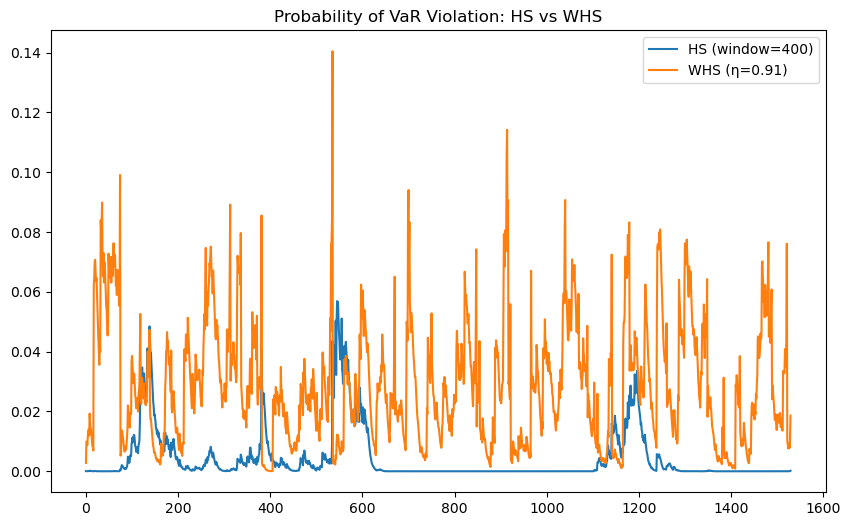

In [72]:
# Question 3 (b) Coding Portion

eta = 0.91
window = 400
VaR_WHS = []

for i in range(window, len(R_sim)):
    past = R_sim.iloc[i-window:i].values
    w = WHS_weights(eta, window)
    VaR_q = weighted_quantile(past, quantile_level, w)
    VaR_WHS.append(VaR_q)

VaR_WHS = np.array(VaR_WHS)
prob_WHS = norm.cdf(VaR_WHS / sigma_path[window:])

# ---------- Plot Part (b) ----------
plt.figure(figsize=(10,6))
plt.plot(prob_HS_400, label="HS (window=400)")
plt.plot(prob_WHS,   label=f"WHS (η={eta})")
plt.legend()
plt.title("Probability of VaR Violation: HS vs WHS")
plt.show()

## Question 3 (b) Written Portion

Comparing Weighted Historical Simulation with a decay factor of 0.91 to a standard Historical Simulation with the same window length of 400 observations, we observed that the weighted method responded more quickly to changes in volatility. This is because exponential weighting increases the importance of recent returns, allowing the model to adapt faster without reducing the sample size. Historical Simulation with a long window reacts slower because it treats all returns equally. Weighted Historical Simulation improves adaptability and better captures periods of sudden volatility changes while retaining some of the smoothing benefits of a larger window.

### <u>*Statement of Collaboration (including ChatGPT)*</u>

I collaborated with **Linsey Zhong** and **Mark Rubin**. Additionally, **ChatGPT** was used to debug any error-prone code and assist with finding proper Python libraries, functions, parameters, etc.

### <u>*Honor Code*</u>
This assignment represents my own work in accordance with University regulations and class policy.